In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
import tensorflow as tf
from tensorflow import keras


2022-09-08 00:24:02.199030: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(
        include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output  # (512 x 512)

    s2 = encoder.get_layer("activation").output  # (255 x 255)
    s2 = ZeroPadding2D(((1, 0), (1, 0)))(s2)  # (256 x 256)

    s3 = encoder.get_layer("activation_3").output  # (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)  # (128 x 128)

    s4 = encoder.get_layer("activation_74").output  # (61 x 61)
    s4 = ZeroPadding2D(((2, 1), (2, 1)))(s4)  # (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output  # (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)  # (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)  # (64 x 64)
    d2 = decoder_block(d1, s3, 256)  # (128 x 128)
    d3 = decoder_block(d2, s2, 128)  # (256 x 256)
    d4 = decoder_block(d3, s1, 64)  # (512 x 512)

    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(6, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model


In [4]:
model = build_inception_resnetv2_unet((512, 512, 3))
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

2022-09-08 00:24:04.709526: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-08 00:24:04.709562: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Andromeda
2022-09-08 00:24:04.709566: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Andromeda
2022-09-08 00:24:04.709670: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-08 00:24:04.709687: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-08 00:24:04.709690: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-09-08 00:24:04.710342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions i

In [5]:
model.load_weights("models/InceptionResNetV2-UNet.h5")

In [6]:
import cv2

image = cv2.imread("sample.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (512, 512))
image = image.reshape(1, 512, 512, 3)

image.shape

(1, 512, 512, 3)

In [7]:
prediction = model.predict(image / 255.0)

1/1 [==============================] - 3s 3s/step


In [8]:
prediction.shape

(1, 512, 512, 6)

In [9]:
id2code = {0: (60, 16, 152),
           1: (132, 41, 246),
           2: (110, 193, 228),
           3: (254, 221, 58),
           4: (226, 169, 41),
           5: (155, 155, 155)}


In [10]:
import numpy as np
def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

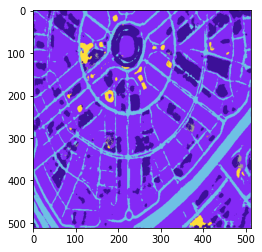

In [11]:
import matplotlib.pyplot as plt

plt.imshow(onehot_to_rgb(prediction[0]))